# Lesson3 系列データで分類・予測させてみよう（RNN, LSTM）

## 目次

- Section1 Checkクイズの解答
- Section2. 実装①
    - 2.0 データの用意
    - 2.1 モデル構築
    - 2.2 モデルの学習
    - 2.3 モデルによる予測
    - 2.4 モデルの可視化

## Section1 Checkクイズの解答

問題1: 2, 問題2: 3

## Section2 実装①

ここでは、以下のページのECGによる波形データセットECG5000をRNNで学習し、分類を行ってみましょう。

http://timeseriesclassification.com/description.php?Dataset=ECG5000

このデータセットは、ECGの計測値140時点分とその系列に対する分類（1～5）で1データとなっており、全体で5000データが含まれています。

### 2.0 データの用意

**ここで利用するデータセットはリポジトリに含まれていません。**

上記リンク先のページ中段にある "Download this dataset" をクリックの上、ご自身でダウンロードして頂くようお願い致します。

ダウンロードしたデータセットはdataフォルダ内に配置していただく必要があります。

データセットの配置が完了したら、まずは配置したデータセットの読み込みを行いましょう。

arffという形式で保存されているため、`scipy.io.loadarff`関数でロードします。

https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html

In [2]:
%matplotlib inline

from scipy.io import arff
import numpy as np

dataset, meta = arff.loadarff('data/ECG5000_TRAIN.arff')

ds = np.asarray(dataset.tolist(), dtype=np.float32)
x_dataset = ds[:, :140]
y_dataset = np.asarray(ds[:,-1].tolist(), dtype=np.int8)-1

In [9]:
print(x_dataset.shape)
print(y_dataset.shape)

(500, 140)
(500,)


実際に表示してみて、様子を確認しておきましょう。

[0 0 0 0 0 0 0 0 0 0]


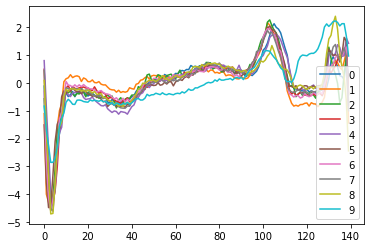

In [3]:
import matplotlib.pyplot as plt

N = 10
print(y_dataset[:N])
obj = plt.plot(x_dataset[:N].T)
plt.legend(obj, [str(n) for n in range(N)])

確かに、分類結果が異なる3,7番はt=100付近でピークを持たないことが見て取れます。

続いて、データセットを訓練用とテスト用に分割します。

In [4]:
# 訓練データとテストデータを分割（＋データの整形）

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(x_dataset[:,:,np.newaxis], to_categorical(y_dataset), test_size=0.2, random_state=42)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(400, 140, 1)
(400, 5)
(100, 140, 1)
(100, 5)


In [31]:
x_train

array([[[-0.82490885],
        [-3.2031746 ],
        [-4.046441  ],
        ...,
        [ 1.1864368 ],
        [ 1.3503627 ],
        [-0.1931861 ]],

       [[ 0.27586484],
        [-0.597149  ],
        [-1.4347785 ],
        ...,
        [-3.0175102 ],
        [-3.9182756 ],
        [-2.7290692 ]],

       [[ 2.4028692 ],
        [ 2.036719  ],
        [ 0.34090236],
        ...,
        [ 2.6139867 ],
        [ 1.9628195 ],
        [ 1.7691982 ]],

       ...,

       [[-0.3430994 ],
        [-1.59714   ],
        [-2.3880904 ],
        ...,
        [-2.3114061 ],
        [-1.5974234 ],
        [ 0.04861622]],

       [[ 2.630225  ],
        [ 1.5530035 ],
        [ 0.28320414],
        ...,
        [-2.252705  ],
        [-1.3000188 ],
        [-0.5765573 ]],

       [[-0.29888216],
        [-2.2209282 ],
        [-3.2456844 ],
        ...,
        [ 1.2373137 ],
        [ 1.4692883 ],
        [ 0.5915854 ]]], dtype=float32)

In [32]:
y_train

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

train : 400回分 x 140の測定結果   
test : 100回分 x 140の測定結果  
label : 0,1,2,3,4のいずれか(one-hot)  

### 2.1 モデル構築

ここでは、先程紹介したSimpleRNNを使用してモデルを構築します。

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN

hid_dim = 10

# SimpleRNNにDenseを接続し、分類
model = Sequential()

# 隠れ層の次元 : 10
# 入力サイズ : (140,1)
model.add(SimpleRNN(hid_dim, input_shape=x_train.shape[1:])) # input_shape=(系列長T, x_tの次元), output_shape=(units(=hid_dim),)
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


### 2.2 モデルの学習


In [6]:
model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=2, validation_split=0.2)

Train on 320 samples, validate on 80 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 0s - loss: 2.0681 - acc: 0.1406 - val_loss: 2.0526 - val_acc: 0.1625
Epoch 2/50
 - 0s - loss: 1.9969 - acc: 0.2062 - val_loss: 1.9930 - val_acc: 0.2125
Epoch 3/50
 - 0s - loss: 1.9286 - acc: 0.2438 - val_loss: 1.9350 - val_acc: 0.2500
Epoch 4/50
 - 0s - loss: 1.8612 - acc: 0.2656 - val_loss: 1.8789 - val_acc: 0.2625
Epoch 5/50
 - 0s - loss: 1.7964 - acc: 0.2875 - val_loss: 1.8240 - val_acc: 0.2625
Epoch 6/50
 - 0s - loss: 1.7316 - acc: 0.3063 - val_loss: 1.7706 - val_acc: 0.2875
Epoch 7/50
 - 0s - loss: 1.6695 - acc: 0.3250 - val_loss: 1.7180 - val_acc: 0.2750
Epoch 8/50
 - 0s - loss: 1.6079 - acc: 0.3406 - val_loss: 1.6667 - val_acc: 0.2875
Epoch 9/50
 - 0s - loss: 1.5495 - acc: 0.3438 - val_loss: 1.6156 - val_acc: 0.2875
Epoch 10/50
 - 0s - loss: 1.4908 - acc: 0.3781 - val_loss: 1.5661 - val_acc: 0.3000
Epoch 11/50
 - 0s - loss: 1.4352 - acc: 0.3906 - val_loss: 1.5184 - val_acc:

### 2.3 モデルによる分類精度の評価

In [13]:
# 性能評価
score = model.evaluate(x_test, y_test, verbose=0)
print('test_loss:', score[0])
print('test_acc:', score[1])

test_loss: 0.6218619883060456
test_acc: 0.87


### 2.4 モデルの可視化

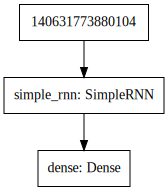

In [14]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 5)                 55        
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________
